## Inital Setup and Data Import

In [53]:
UseCalibration = 1

In [54]:
import numpy as np
import pandas as pd
import re as re
import pickle

from sklearn.preprocessing import Imputer

import matplotlib.pyplot as plt
import seaborn as sns
import time
import scipy.stats as st
import scipy.special as spec
import math

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,StratifiedKFold, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, precision_score, recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, RandomForestRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

from math import log

from boostaroota import BoostARoota
from xgboost import XGBClassifier, plot_importance

##########

import warnings
warnings.filterwarnings("ignore")

import nbimporter
#from libraries_setup import AllLibraries
from setup_code import *

#AllLibraries()

###### Installing packages ##########
# import sys
# !{sys.executable} -m pip install boostaroota

In [55]:
data = pd.read_csv('train.csv')
data.set_index('PassengerId', inplace=True)


scoring = pd.read_csv('test.csv')
scoring.set_index('PassengerId', inplace=True)

In [56]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
y = data.loc[:,'Survived']
X = data.drop ('Survived', 1)

In [58]:
random = 1992
test_prc = 0.2

if UseCalibration==1:
    calib_size = 0.1
else:
    calib_size = 0

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size = test_prc, random_state = random)
X_train , X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = calib_size, random_state = random + 50)

In [59]:
data_train = X_train
data_train['Survived'] = y_train

data_test = X_test
data_test['Survived'] = y_test

data_calib = X_calib
data_calib['Survived'] = y_calib

if UseCalibration==1:
    datasets_all = [data_calib, data_train, data_test, scoring]
else:
    datasets_all = [data_train, data_test, scoring]

In [60]:
data_calib.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
PassengerId,,,,,,,,,,,
757,3,"Carlsson, Mr. August Sigfrid",male,28.0,0,0,350042,7.7958,NaN,S,0
168,3,"Skoog, Mrs. William (Anna Bernhardina Karlsson)",female,45.0,1,4,347088,27.9000,NaN,S,0
21,2,"Fynney, Mr. Joseph J",male,35.0,0,0,239865,26.0000,NaN,S,0
38,3,"Cann, Mr. Ernest Charles",male,21.0,0,0,A./5. 2152,8.0500,NaN,S,0
510,3,"Lang, Mr. Fang",male,26.0,0,0,1601,56.4958,NaN,S,1


In [61]:
##maybe i should split feature engineering into "might create overfitting" vs not

In [62]:
#ShowTypes(data_train)
ShowLevels(data_train)

Number of records in the dataset is  640
 
Number of  Name  levels:  640
Number of  Sex  levels:  2
Number of  Ticket  levels:  522
Number of  Cabin  levels:  118
Number of  Embarked  levels:  3


In [63]:
############### FEATURE ENGINEERING ####################

##### Creating variables

for data in datasets_all:
    create_new_var (data)

In [64]:
#### Impact Coding

if UseCalibration==1:
    
    variables_to_code = ['Cabin', 'Ticket', 'Last_name', 'Other_last_name', 'Ticket_first', 'Ticket_second']

    for variable in variables_to_code:

        impact_variable_name = variable + '_impact'

        #create impact coding  on calibration
        data_calib = impact_coding(data_calib, variable)

        #apply impact coding to all other data sets, and fill NAs with 0 when there is no match
        coded_impacts = data_calib[[variable, impact_variable_name]].drop_duplicates()

        data_train = data_train.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
        data_train[impact_variable_name] = data_train[impact_variable_name].fillna(0)

        data_test = data_test.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
        data_test[impact_variable_name] = data_test[impact_variable_name].fillna(0)

        scoring = scoring.reset_index().merge(coded_impacts, on=variable, how = 'left').set_index('PassengerId')
        scoring[impact_variable_name] = scoring[impact_variable_name].fillna(0)

In [65]:
ShowTypes(data_train)

 Categorical variables of the dataset are: 

Name
Sex
Ticket
Cabin
Embarked
Title
Last_name
Other_full_name
Other_last_name
Cabin_letter
Ticket_first
Ticket_second
 
 Numerical variables of the dataset are: 

Pclass
Age
SibSp
Parch
Fare
Survived
FamilySize
IsAlone
Cabin_impact
Ticket_impact
Last_name_impact
Other_last_name_impact
Ticket_first_impact
Ticket_second_impact


In [66]:
##### Correct variables' formats
datasets_all = [data_calib, data_train, data_test, scoring]

variables_to_categories = ['Pclass', 'IsAlone', 'SibSp', 'Parch', 'FamilySize']
to_type = 'object'

for data in datasets_all:
    for variable in variables_to_categories:
        data.loc[:,variable] = data[variable].astype(to_type)
        
for data in datasets_all:
    for variable in ['SibSp', 'Parch','FamilySize']:
        data.loc[data[variable].isin ([0,1,2,3,4]) == False , variable]  = '5+'

In [67]:
##### Imputations (for regression imputer your columns have to have the proper format)

data_train = impute_most_frequent (data_train, 'Embarked')
data_test = impute_most_frequent (data_test, 'Embarked')
scoring = impute_most_frequent (scoring, 'Embarked')

if UseCalibration==1:
    data_calib = impute_most_frequent (data_calib, 'Embarked')


data_train = impute_regressor(data_train, 'Age', 1)
data_test = impute_regressor(data_test, 'Age', 1)
scoring = impute_regressor(scoring, 'Age', 1)
if UseCalibration==1:
    data_calib = impute_regressor(data_calib, 'Age', 1)
    
    
scoring = impute_regressor(scoring, 'Fare', 0)

In [68]:
#list(data_train)
ShowLevels(data_train)

Number of records in the dataset is  640
 
Number of  Pclass  levels:  3
Number of  Name  levels:  640
Number of  Sex  levels:  2
Number of  SibSp  levels:  6
Number of  Parch  levels:  6
Number of  Ticket  levels:  522
Number of  Cabin  levels:  118
Number of  Embarked  levels:  3
Number of  FamilySize  levels:  5
Number of  IsAlone  levels:  2
Number of  Title  levels:  7
Number of  Last_name  levels:  512
Number of  Other_full_name  levels:  105
Number of  Other_last_name  levels:  104
Number of  Cabin_letter  levels:  7
Number of  Ticket_first  levels:  33
Number of  Ticket_second  levels:  512
Number of  AgeIsBad  levels:  2


In [69]:
variables_to_delete = ['Name', 'Ticket', 'Cabin', 'Last_name','Other_full_name', 'Other_last_name', 
                       'Ticket_first', 'Ticket_second']

for variable in variables_to_delete:
    
    data_train = data_train.drop (variable, 1) # 1 for columns, 0 for rows
    data_test = data_test.drop (variable, 1) 
    scoring = scoring.drop (variable, 1) 
    
    if UseCalibration==1:
        data_calib = data_calib.drop (variable, 1)

In [70]:
data_train.to_csv('check.csv', index = True, header = True)
data_train.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Survived,FamilySize,IsAlone,Title,Cabin_letter,Cabin_impact,Ticket_impact,Last_name_impact,Other_last_name_impact,Ticket_first_impact,Ticket_second_impact,AgeIsBad
PassengerId,,,,,,,,,,,,,,,,,,,
888,1,female,19.000000,0,0,30.0000,S,1,1,1,Miss,B,0.0,0.0,0.0,0.0,0.0,0.0,0
493,1,male,55.000000,0,0,30.5000,S,0,1,1,Mr,C,0.0,0.0,0.0,0.0,0.0,0.0,0
637,3,male,32.000000,0,0,7.9250,S,0,1,1,Mr,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
262,3,male,3.000000,4,2,31.3875,S,1,5+,0,Master,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0
860,3,male,26.593095,0,0,7.2292,C,0,1,1,Mr,NaN,0.0,0.0,0.0,0.0,0.0,0.0,1


In [71]:
ShowTypes(data_train)

 Categorical variables of the dataset are: 

Pclass
Sex
SibSp
Parch
Embarked
FamilySize
IsAlone
Title
Cabin_letter
AgeIsBad
 
 Numerical variables of the dataset are: 

Age
Fare
Survived
Cabin_impact
Ticket_impact
Last_name_impact
Other_last_name_impact
Ticket_first_impact
Ticket_second_impact


In [72]:
data_train = create_dummies(data_train,0)
data_test = create_dummies(data_test,0)
scoring = create_dummies(scoring,0)

if UseCalibration==1:
    data_calib = create_dummies(data_calib,0)

In [76]:
list(scoring)

['Age',
 'Fare',
 'Cabin_impact',
 'Ticket_impact',
 'Last_name_impact',
 'Other_last_name_impact',
 'Ticket_first_impact',
 'Ticket_second_impact',
 'Pclass_1',
 'Pclass_2',
 'Pclass_3',
 'Sex_female',
 'Sex_male',
 'SibSp_0',
 'SibSp_1',
 'SibSp_2',
 'SibSp_3',
 'SibSp_4',
 'SibSp_5+',
 'Parch_0',
 'Parch_1',
 'Parch_2',
 'Parch_3',
 'Parch_4',
 'Parch_5+',
 'Embarked_C',
 'Embarked_Q',
 'Embarked_S',
 'FamilySize_1',
 'FamilySize_2',
 'FamilySize_3',
 'FamilySize_4',
 'FamilySize_5+',
 'IsAlone_0',
 'IsAlone_1',
 'Title_Dr',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Rare',
 'Title_Rev',
 'Cabin_letter_A',
 'Cabin_letter_B',
 'Cabin_letter_C',
 'Cabin_letter_D',
 'Cabin_letter_E',
 'Cabin_letter_F',
 'Cabin_letter_G',
 'AgeIsBad_0.0',
 'AgeIsBad_1.0']

In [78]:
# interaction variables

datasets_all = [data_calib, data_train, data_test, scoring]

for data in datasets_all:
    data['Age_Pclass_1']= data['Age'] * data['Pclass_1']
    data['Age_Pclass_2']= data['Age'] * data['Pclass_2']
    data['Age_Pclass_3']= data['Age'] * data['Pclass_3']
    #data.loc[:,'Age_Class'] = data['Age_Class'].astype('float32')

In [79]:
#### Feature Selection

# BoostARoota from: https://github.com/chasedehan/BoostARoota# BoostAR 
br = BoostARoota(metric='logloss', silent=True)

y_train = data_train.loc[:,'Survived']
X_train = data_train.drop ('Survived', 1)

br.fit(X_train,y_train)
X_train_reduced = br.transform(X_train)

print("The algorithm reduced the data from " + str(X_train.shape[1]) + " to " + 
      str(X_train_reduced.shape[1]) + " variables")

The algorithm reduced the data from 54 to 31 variables


In [80]:
important_variables = list (X_train_reduced)
#important_variables = list (X_train)

In [81]:
#ShowTypes(data_train)
#data_train.isna().sum()
#ShowLevels(data_calib)

## Modeling

In [82]:
y_train = data_train.loc[:,'Survived']
X_train = data_train.loc[:, important_variables]

y_test = data_test.loc[:,'Survived']
X_test = data_test.loc[:, important_variables]

X_scoring = scoring.loc[:, important_variables]

In [83]:
print ("Check: \n" + 
       "Training size is " + str(X_train.shape) + "\n" + 
       "Testing size is " + str(X_test.shape) + "\n" + 
       "Scoring size is " + str(X_scoring.shape) 
      )

Check: 
Training size is (640, 31)
Testing size is (179, 31)
Scoring size is (418, 31)


In [84]:
X_test.head()

,Age,Fare,Ticket_impact,Other_last_name_impact,Ticket_first_impact,Pclass_1,Pclass_3,Sex_female,SibSp_0,Parch_0,...,Cabin_letter_A,Cabin_letter_B,Cabin_letter_C,Cabin_letter_D,Cabin_letter_E,Cabin_letter_G,AgeIsBad_0.0,Age_Pclass_1,Age_Pclass_2,Age_Pclass_3
PassengerId,,,,,,,,,,,,,,,,,,,,,
144,19.0,6.7500,0.0,0.0,0.000000,0,1,0,1,1,...,0,0,0,0,0,0,1,0.0,0.0,19.0
117,70.5,7.7500,0.0,0.0,0.000000,0,1,0,1,1,...,0,0,0,0,0,0,1,0.0,0.0,70.5
105,37.0,7.9250,0.0,0.0,0.000000,0,1,0,0,1,...,0,0,0,0,0,0,1,0.0,0.0,37.0
65,29.6,27.7208,0.0,0.0,1.139404,1,0,0,1,1,...,0,0,0,0,0,0,0,29.6,0.0,0.0
447,13.0,19.5000,0.0,0.0,0.000000,0,0,1,1,0,...,0,0,0,0,0,0,1,0.0,13.0,0.0


### Parameter Tuning

In [85]:
############################ TUNNING RANDOM FOREST ########################################

# rf = RandomForestClassifier()
# #rf.get_params()

# row_num = X_train.shape[0]

# n_estimators_start = 200
# n_estimators_end =  2000

# max_depth_start = 10
# max_depth_end = 110

# min_samples_split_start =  round(0.01*row_num) #2
# min_samples_split_end = round(0.03*row_num) #10

# min_samples_leaf_start = 1
# min_samples_leaf_end = 20 #4


# max_features = ['auto', 'sqrt']
# bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': st.randint (n_estimators_start, n_estimators_end),
#                'max_depth': st.randint (max_depth_start, max_depth_end),
#                'min_samples_split': st.randint (min_samples_split_start, min_samples_split_end),
#                'min_samples_leaf': st.randint (min_samples_leaf_start, min_samples_leaf_end),
#                'max_features': max_features,
#                'bootstrap': bootstrap}


# rf_random = RandomizedSearchCV(estimator = rf, 
#                                            param_distributions = random_grid, 
#                                            n_iter = 100, cv = 5, scoring = 'roc_auc', verbose=False, 
#                                            random_state=42, n_jobs = -1)

# start = time.time()
# rf_random.fit(X_train,y_train)
# end = time.time()

# print("Execution Time Was: ", end - start, "seconds")

# RandomForestClassifierTuned = RandomForestClassifier()
# RandomForestClassifierTuned.set_params(**rf_random.best_params_)

##########################################################################################

In [86]:
############################ TUNNING GRADIENT BOOSTING ########################################

#best model (roc = 82.727483): with n_est 3 - 40; max_depth 3-40; learning rate 0.05 - 0.4

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# consider using GridSearchCV

gb = GradientBoostingClassifier()
#rf.get_params()

row_num = X_train.shape[0]

learning_rate_start = 0.09 #0.03
learning_rate_end = 0.2 #0.3

n_estimators_start = 3
n_estimators_end =  40 #80

max_depth_start = 3
max_depth_end = 40 #20

min_samples_split_start = round(0.01*row_num)
min_samples_split_end = round(0.03*row_num)

min_samples_leaf_start = 1
min_samples_leaf_end = 20 


random_grid = {  
                "learning_rate": st.uniform (learning_rate_start, learning_rate_end),
                "n_estimators": st.randint (n_estimators_start, n_estimators_end),
                "max_depth": st.randint (max_depth_start, max_depth_end)
            }


# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
gb_random = RandomizedSearchCV(estimator = gb, 
                                           param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'roc_auc', verbose=False, 
                                           random_state=42, n_jobs = -1)


start = time.time()
gb_random.fit(X_train,y_train)
end = time.time()

print("Execution Time Was: ", end - start, "seconds")

GradientBoostingClassifierTuned = GradientBoostingClassifier()
GradientBoostingClassifierTuned.set_params(**gb_random.best_params_)
GradientBoostingClassifierTuned.get_params()
############################################################################################

Execution Time Was:  24.757081031799316 seconds


{'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.13655426808606086,
 'loss': 'deviance',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 39,
 'presort': 'auto',
 'random_state': None,
 'subsample': 1.0,
 'verbose': 0,
 'warm_start': False}

In [87]:
############################ TUNNING XGBOOST ########################################

#https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
# consider using GridSearchCV

xgb = XGBClassifier()
#rf.get_params()

row_num = X_train.shape[0]

learning_rate_start = 0.05
learning_rate_end = 0.4

n_estimators_start = 3
n_estimators_end =  80

max_depth_start = 3
max_depth_end = 50

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

random_grid = {  
    "n_estimators": st.randint(n_estimators_start, n_estimators_end),
    "max_depth": st.randint(max_depth_start, max_depth_end),
    "learning_rate": st.uniform(learning_rate_start, learning_rate_end),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive
}

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, 
                                           param_distributions = random_grid, 
                                           n_iter = 100, cv = 10, scoring = 'roc_auc', verbose=False, 
                                           random_state=42, n_jobs = -1)


start = time.time()
xgb_random.fit(X_train,y_train)
end = time.time()

print("Execution Time Was: ", end - start, "seconds")

XGBClassifierTuned = XGBClassifier()
XGBClassifierTuned.set_params(**xgb_random.best_params_)
XGBClassifierTuned.get_params()
#####################################################################################

Execution Time Was:  5.132575988769531 seconds


{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bytree': 0.9697415755070925,
 'gamma': 6.0789439379425865,
 'learning_rate': 0.20172227935421955,
 'max_delta_step': 0,
 'max_depth': 11,
 'min_child_weight': 11.507137456078535,
 'missing': None,
 'n_estimators': 59,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 0,
 'reg_alpha': 0.23213920331714424,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': True,
 'subsample': 0.9622365109010307}

### Comparing Different Classifiers

In [88]:
classifiers = [
    KNeighborsClassifier(3),
  # SVC(kernel="rbf", C=0.025, probability=True),
    NuSVC(probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
  #  GaussianNB(),
  #  LinearDiscriminantAnalysis(),
  #  QuadraticDiscriminantAnalysis(),
    XGBClassifier(),
 #   RandomForestClassifierTuned,
    GradientBoostingClassifierTuned,
    XGBClassifierTuned
]

names = [
        'KNeighborsClassifier',
   #     'Support Vector Machine',
        'NuSVC',
        'Decision Tree',
        'Random Forest',
        'AdaBoost',
        'Gradient Boosting',
   #     'Gaussian NB',
   #     'Linear Discriminant Analysis',
   #     'Quadratic Discriminant Analysis',
        'XGBoost',
   #     'Random Forest Tuned',
        'Gradient Boosting Tuned',
        'XGBoost Tuned'
]

In [89]:
folds = 10
random = 23
test_prc = 0.3

#X_train , X_test, y_train, y_test = train_test_split( X, y, test_size = test_prc, random_state = random)

sss = StratifiedShuffleSplit(n_splits = folds, test_size=test_prc, random_state=random)
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = random)


log_cols=["Index", "Classifier", "ROC", "Accuracy", "Log Loss", 'Precision', 'Recall']
log = pd.DataFrame(columns=log_cols)

index = 0

for train_index, test_index in skf.split(X_train, y_train):
    
    index += 1
    
    X_train_kf, X_test_kf = X_train.values[train_index], X_train.values[test_index]
    y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    # FOR MORE METRICS SEE: http://scikit-learn.org/stable/modules/model_evaluation.html

    for name, clf in zip(names,classifiers):

        clf.fit(X_train_kf, y_train_kf)

        y_pred_kf = clf.predict(X_test_kf)
        y_pred_prob_kf = clf.predict_proba(X_test_kf)

        #name = clf.__class__.__name__

        roc = 100*roc_auc_score(y_test_kf, y_pred_kf)
        acc = 100*accuracy_score(y_test_kf, y_pred_kf)
        ll = log_loss(y_test_kf, y_pred_prob_kf)

        prec = 100*precision_score(y_test_kf, y_pred_kf)
        recall = 100*recall_score(y_test_kf, y_pred_kf)

        log_entry = pd.DataFrame([[index, name, roc, acc, ll, prec, recall]], columns=log_cols)
        log = log.append(log_entry)

#log
final_log = log.groupby(['Classifier'])["ROC", "Accuracy", "Log Loss", 'Precision', 'Recall'].mean()
final_log.sort_values(by = 'ROC', ascending = False, inplace = True)

In [90]:
final_log

,ROC,Accuracy,Log Loss,Precision,Recall
Classifier,,,,,
Gradient Boosting,82.393590,83.916132,0.414205,81.511270,75.716667
XGBoost,81.663462,83.288576,0.410229,80.749465,74.500000
AdaBoost,81.321795,82.338752,0.667359,77.421695,76.900000
Gradient Boosting Tuned,80.746154,82.189789,0.424846,78.521014,74.466667
Random Forest,80.627564,82.206998,1.614159,78.769665,73.716667
XGBoost Tuned,78.265385,80.780830,0.433340,79.934594,67.216667
Decision Tree,76.412821,77.667773,7.671984,73.191484,71.133333
NuSVC,68.920513,72.185936,0.553783,67.284627,54.616667
KNeighborsClassifier,67.855769,70.791629,3.828869,64.771221,55.000000


### Running The Model

In [68]:
# running on the whole dataset
best_classifier = GradientBoostingClassifierTuned #GradientBoostingClassifierTuned
best_classifier.fit(X_train, y_train)

y_pred = best_classifier.predict(X_test)
y_pred_prob = best_classifier.predict_proba(X_test)

#X_test['Survived_pred'] = y_pred
acc = 100*accuracy_score(y_test, y_pred)
acc

79.88826815642457

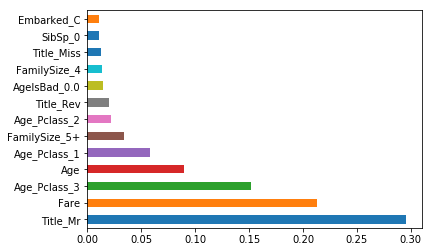

In [69]:
features_plot = pd.Series(best_classifier.feature_importances_, index=X_test.columns).nlargest(13).plot(kind='barh')

## Submitting to Kaggle

In [70]:
# running on the whole dataset
y = pd.concat([y_train, y_test])
X = pd.concat([X_train, X_test])
X_scoring = scoring.loc[:, important_variables]

In [71]:
#X.isna().sum()
# X['Cabin_letter_T'] = X['Cabin_letter_T'].fillna(0)
# X['Cabin_letter_F'] = X['Cabin_letter_F'].fillna(0)

# X_scoring['Cabin_letter_F'] = X_scoring['Cabin_letter_F'].fillna(0)
# X_scoring['Cabin_letter_T'] = 0

In [72]:
print ("Check: \n" + 
       "Scoring size is " + str(X_scoring.shape) + "\n" + 
       "Training size is " + str(X.shape) + "\n"
      )

Check: 
Scoring size is (418, 25)
Training size is (891, 25)



In [73]:
best_classifier.fit(X, y)

y_pred = best_classifier.predict(X_scoring)
#y_pred_prob = best_classifier.predict_proba(X_scoring)

In [74]:
X_scoring['Survived'] = y_pred

submission = X_scoring[['Survived']]
submission.reset_index(inplace=True)
submission.to_csv('submission.csv', index = False, header = True)

In [75]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
